In [1]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib
!pip install catboost

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

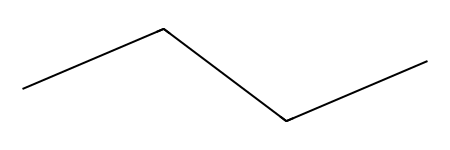

In [2]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [3]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Optional) Feature scaling
from sklearn.preprocessing import StandardScaler

# CatBoost
# pip install catboost
from catboost import CatBoostRegressor

def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    """
    Convert a SMILES string to a Morgan fingerprint (ECFP) vector of length n_bits.
    Returns a NumPy array of shape (n_bits,) or None if SMILES is invalid.

    Here, n_bits=256 to reduce dimensionality (instead of 1024).
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

def main():
    # 1. Load your CSV dataset (adjust filename/columns if needed)
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(52))  # Quick check of the data
    
    # 2. Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # 3. Convert SMILES to numeric features (256-bit Morgan fingerprints)
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # --- NEW: Log-transform the target ---
    # If Enhancement Factor is always > 0, log transform can reduce MSE significantly.
    y_train_log = np.log1p(y_train)  # log(1 + EF)
    y_test_log  = np.log1p(y_test)
    
    # 5. (Optional) Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # 6. Define and train a CatBoost regressor
    #    (same hyperparameters, but now it sees log(EF))
    model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=False
    )
    model.fit(X_train_scaled, y_train_log)
    
    # 7. Evaluate on the test set
    #    Predict in log space, then exponentiate
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)  # revert to original EF scale
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Adjusted R²
    n = len(y_test)
    p = X_test_scaled.shape[1]
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adjusted_r2 = float('nan')
    
    print("\n=== CatBoost Model (Test Set) ===")
    print("Log-transform of Enhancement Factor + 256-bit fingerprints")
    print("iterations=300, learning_rate=0.1, depth=6")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    
    # 8. (Optional) Retrain on all data for new SMILES predictions
    final_model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        random_seed=42,
        verbose=False
    )
    # Scale entire dataset
    X_scaled = scaler.fit_transform(X)
    # Fit on log(EF) again
    y_log_all = np.log1p(y)
    final_model.fit(X_scaled, y_log_all)
    
    # 9. Interactive SMILES input
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        new_fp_scaled = scaler.transform([new_fp])
        # Predict in log space, then exponentiate
        pred_log = final_model.predict(new_fp_scaled)[0]
        pred_val = np.expm1(pred_log)
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()



    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    
18   19                   Cefixime    
19   20        Cefpodoxime proxetil   
20   21                   Ceftiofur   
21   22                     Danazol   
22   23                Ketoconazole   
23   24                 Mebendazole   
24   25      Metronidazol

[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerator
[21:05:12] DEPRECATION WARNING: please use MorganGenerat


=== CatBoost Model (Test Set) ===
Log-transform of Enhancement Factor + 256-bit fingerprints
iterations=300, learning_rate=0.1, depth=6
MSE  : 144620.4558
RMSE : 380.2900
MAE  : 174.9201
R²   : -0.1807
Adjusted R²: nan

=== Predict Enhancement Factor for a new SMILES ===
Enter a SMILES string (or type 'quit' to exit): quit
Exiting.


Here is a much more improved version of dataset below
=
=
=
=
=
=
=+

In [ ]:
#!/usr/bin/env python
import pandas as pd
import numpy as np

# RDKit for SMILES parsing
from rdkit import Chem
from rdkit.Chem import AllChem

# For train-test split, cross-validation, metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# CatBoost
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # suppress catboost logs if needed

#############################################
# 1. Utility: SMILES -> 256-bit fingerprint
#############################################
def smiles_to_morgan_fp(smi, radius=2, n_bits=256):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    for i in range(n_bits):
        if fp.GetBit(i):
            arr[i] = 1
    return arr

#############################################
# 2. Main
#############################################
def main():
    file_path = 'C:/Users/gagno/Downloads/molecule_dataset.csv'
    df = pd.read_csv(file_path)
    print(df.head(60))  # quick peek
    
    # Basic cleaning
    df = df.replace([np.inf, -np.inf], np.nan)
    df["Enhancement Factor"] = pd.to_numeric(df["Enhancement Factor"], errors='coerce')
    df.dropna(subset=["Smiles", "Enhancement Factor"], inplace=True)
    
    # Convert SMILES -> 256-bit fingerprints
    smiles_list = df["Smiles"].astype(str).tolist()
    enhancement_factors = df["Enhancement Factor"].values
    
    X_fps = []
    valid_y = []
    for smi, val in zip(smiles_list, enhancement_factors):
        fp = smiles_to_morgan_fp(smi, radius=2, n_bits=256)
        if fp is not None:
            X_fps.append(fp)
            valid_y.append(val)
    
    X = np.array(X_fps, dtype=float)
    y = np.array(valid_y, dtype=float)
    
    #############################################
    # 3. Log-transform the target
    #############################################
    # Ensure EF > 0 or handle zeros carefully
    y_log = np.log1p(y)
    
    #############################################
    # 4. Remove outliers in log space
    #############################################
    # If some log(EF) values are extremely large, remove them.
    # For example, remove points > 3 std from the mean in log space.
    mean_log = np.mean(y_log)
    std_log  = np.std(y_log)
    z_scores = (y_log - mean_log) / std_log
    
    # keep points with |z_scores| <= 3
    keep_mask = np.abs(z_scores) <= 3
    X = X[keep_mask]
    y = y[keep_mask]
    y_log = y_log[keep_mask]
    print(f"Removed {np.sum(~keep_mask)} outliers in log space.")
    print(f"Remaining data points: {len(y)}")
    
    if len(y) < 10:
        print("Warning: Fewer than 10 data points remain after outlier removal!")
    
    #############################################
    # 5. Feature scaling
    #############################################
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #############################################
    # 6. Repeated Cross-Validation + Random Search
    #############################################
    from sklearn.model_selection import RandomizedSearchCV
    
    cat_base = CatBoostRegressor(
        verbose=False,
        random_seed=42,
        loss_function='RMSE'
    )
    
    # Larger param distributions for random search
    param_distributions = {
        'iterations':    [300, 500, 700, 1000],
        'depth':         [4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'l2_leaf_reg':   [1, 3, 5, 7, 9, 11],
        'bagging_temperature': [0, 0.5, 1, 2, 5],
        'subsample':     [0.8, 1.0],   # random strength
    }
    
    # RepeatedKFold for more robust estimation
    # e.g., 5 folds repeated 3 times = 15 total folds
    cv_folds = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    
    # We'll do 40 random searches
    n_iter_search = 40
    
    random_search = RandomizedSearchCV(
        estimator=cat_base,
        param_distributions=param_distributions,
        n_iter=n_iter_search,
        scoring='neg_mean_squared_error',
        cv=cv_folds,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_scaled, y_log)
    
    print("\n=== Best Hyperparameters from RandomizedSearch ===")
    print(random_search.best_params_)
    print(f"Best CV Score (neg MSE, log space): {random_search.best_score_:.4f}")
    
    best_cat = random_search.best_estimator_
    
    #############################################
    # 7. Evaluate best model in cross-validation
    #############################################
    from statistics import mean, stdev
    
    # We'll do a final repeated cross-val check
    cv_mses = []
    for train_idx, test_idx in cv_folds.split(X_scaled):
        X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
        y_train_cv, y_test_cv = y_log[train_idx], y_log[test_idx]
        best_cat.fit(X_train_cv, y_train_cv)
        y_pred_cv_log = best_cat.predict(X_test_cv)
        # exponentiate
        y_pred_cv = np.expm1(y_pred_cv_log)
        y_true_cv = np.expm1(y_test_cv)
        fold_mse = mean_squared_error(y_true_cv, y_pred_cv)
        cv_mses.append(fold_mse)
    
    mean_mse = mean(cv_mses)
    std_mse = stdev(cv_mses)
    print(f"\nFinal RepeatedCV MSE (original EF scale): {mean_mse:.4f} ± {std_mse:.4f}")
    
    #############################################
    # 8. Retrain on entire dataset
    #############################################
    best_cat.fit(X_scaled, y_log)
    
    y_pred_all_log = best_cat.predict(X_scaled)
    y_pred_all = np.expm1(y_pred_all_log)
    
    mse_final = mean_squared_error(y, y_pred_all)
    rmse_final = np.sqrt(mse_final)
    mae_final = mean_absolute_error(y, y_pred_all)
    r2_final = r2_score(y, y_pred_all)
    
    print("\n=== Final Model on Entire (Outlier-Trimmed) Dataset ===")
    print(f"MSE  : {mse_final:.4f}")
    print(f"RMSE : {rmse_final:.4f}")
    print(f"MAE  : {mae_final:.4f}")
    print(f"R²   : {r2_final:.4f}")
    
    #############################################
    # 9. Interactive SMILES input
    #############################################
    print("\n=== Predict Enhancement Factor for a new SMILES ===")
    while True:
        user_input = input("Enter a SMILES string (or type 'quit' to exit): ").strip()
        if user_input.lower() == 'quit':
            print("Exiting.")
            break
        
        new_fp = smiles_to_morgan_fp(user_input, radius=2, n_bits=256)
        if new_fp is None:
            print("Invalid SMILES entered. Please try again.\n")
            continue
        
        new_fp_scaled = scaler.transform([new_fp])
        pred_log = best_cat.predict(new_fp_scaled)[0]
        pred_val = np.expm1(pred_log)
        print(f"Predicted Enhancement Factor: {pred_val:.4f}\n")

if __name__ == "__main__":
    main()




    ID                         Name  \
0     1         Ibuprofen / HP-B-CD   
1     2      Dexamethasone / B - CD   
2     3         Piroxicam / HP-B-CD   
3     4    Hydrocortisone / HP-B-CD   
4     5       Albendazole / RM-B-CD   
5     6            Valtarsan / B-CD   
6     7        Nifedipine / HP-B-CD   
7     8        Nimodipine / HP-B-CD   
8     9     Carbamazepine / HP-B-CD   
9    10      Itraconazole / HP-B-CD   
10   11       Simvastatin / HP-B-CD   
11   12          Curcumin / HP-B-CD   
12   13  Indomethacin / HP- B - CD    
13   14     Naproxen / HP - B - CD    
14   15        Diclofenac / HP-B-CD   
15   16   Resveratrol / HP-Gamma CD   
16   17              Amphotericin B   
17   18                 Budesonide    
18   19                   Cefixime    
19   20        Cefpodoxime proxetil   
20   21                   Ceftiofur   
21   22                     Danazol   
22   23                Ketoconazole   
23   24                 Mebendazole   
24   25      Metronidazol

[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerator
[21:53:51] DEPRECATION WARNING: please use MorganGenerat


=== Best Hyperparameters from RandomizedSearch ===
{'subsample': 0.8, 'learning_rate': 0.01, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 10, 'bagging_temperature': 0}
Best CV Score (neg MSE, log space): -5.4294

Final RepeatedCV MSE (original EF scale): 32222397.8358 ± 38971780.1703

=== Final Model on Entire (Outlier-Trimmed) Dataset ===
MSE  : 31280716.0536
RMSE : 5592.9166
MAE  : 1426.6579
R²   : -0.0462

=== Predict Enhancement Factor for a new SMILES ===
